# SVMs classifier 

Links to papers and related information:

https://www.academia.edu/105567508/Design_of_Automatic_Number_Plate_Recognition_System_for_Yemeni_Vehicles_with_Support_Vector_Machine?nav_from=589832a2-802f-4a39-88b6-e15bc16559e1

https://www.academia.edu/73123341/Saudi_License_Plate_Recognition_Algorithm_Based_on_Support_Vector_Machine?nav_from=4994dbac-b96a-4746-ac91-52791c1b17b3

https://www.academia.edu/110187161/SVM_Based_License_Plate_Recognition_System?nav_from=36dcd588-c2c0-48f5-bf6c-6a6e18d1b73d


One-vs-one

One-vs-many

## Part II: Segmentation

### Libraries and general functions

In [30]:
import os
from os import listdir
import cv2
from matplotlib import pyplot as plt
import numpy as np
from skimage.transform import resize
import imutils

In [31]:
def delete_borders(image):
    """
    Function to delete borders by iterating white pixels 
    touching borders and doing Floodfill
    """
    out_image = image.copy()
    h, w = image.shape[:2]
    for row in range(h):
        if out_image[row, 0] == 255:
            cv2.floodFill(out_image, None, (0, row), 0)
        if out_image[row, w - 1] == 255:
            cv2.floodFill(out_image, None, (w - 1, row), 0)
    for col in range(w):
        if out_image[0, col] == 255:
            cv2.floodFill(out_image, None, (col, 0), 0)
        if out_image[h - 1, col] == 255:
            cv2.floodFill(out_image, None, (col, h - 1), 0)
    return out_image

### Acquisition of the image

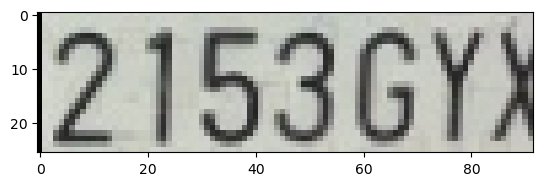

In [32]:
plate_path = "PlateImages/Frontal/plate_2153GYX.jpg"
plate = cv2.imread(plate_path)
plt.imshow(plate)

### Preprocessing the image

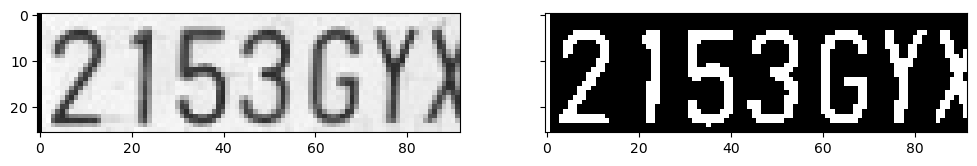

In [33]:
# Convert to grayscale
gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
# Apply Gaussian Blur to smooth noise
blur = cv2.GaussianBlur(gray,(1,1),0)
# Threshold the image to binarize
binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
ax1.imshow(blur, cmap= 'gray')
ax2.imshow(binary, cmap= 'gray')

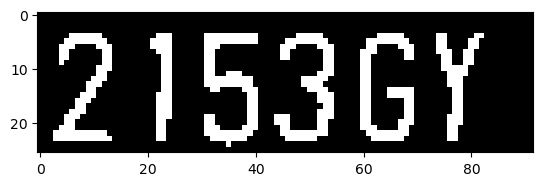

In [34]:
no_borders = delete_borders(binary)
plt.imshow(no_borders, cmap="gray")

8


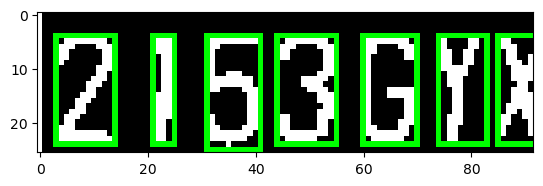

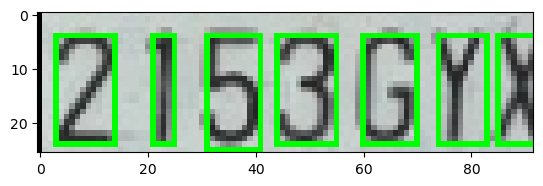

In [49]:
# Find contours in the binary image
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours based on contour area (descending order)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Select top 7 largest contours (representing the 7 digits of the plate)
largest_contours = contours[:7]

# Sort largest contours from left to right based on the x-coordinate of the bounding rectangles
largest_contours.sort(key=lambda c: cv2.boundingRect(c)[0])

# Make a copy to conserve original image
im_copy_binary = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

# List to store the character images
character_images = []

# Loop over contours to extract characters
for contour in largest_contours:
    # Get the bounding box around each contour
    x, y, w, h = cv2.boundingRect(contour)

    # Filter out small regions that may not be characters (based on size heuristics)
    if h > 15 and w > 3:  # These thresholds can be adjusted based on plate image quality
        char_image = im_copy_binary[y:y+h, x:x+w]  # Crop the character from the image
        character_images.append(char_image)

        # Optionally, draw bounding boxes on the original image for visualization
        cv2.rectangle(im_copy_binary, (x, y), (x + w, y + h), (0, 255, 0), 1)

# Show the result
plt.imshow(cv2.cvtColor(im_copy_binary, cv2.COLOR_BGR2RGB))  #convert BGR to RGB for display purposes
plt.show()


# Make a copy to conserve original image
im_copy_plate = plate.copy()

# Loop over contours to extract characters
for contour in contours:
    # Get the bounding box around each contour
    x, y, w, h = cv2.boundingRect(contour)

    # Filter out small regions that may not be characters (based on size heuristics)
    if h > 15 and w > 3:  # These thresholds can be adjusted based on plate image quality
        char_image = im_copy_plate[y:y+h, x:x+w]  # Crop the character from the image
        character_images.append(char_image)

        # Optionally, draw bounding boxes on the original image for visualization
        cv2.rectangle(im_copy_plate, (x, y), (x + w, y + h), (0, 255, 0), 1)

# Show the result
plt.imshow(cv2.cvtColor(im_copy_plate, cv2.COLOR_BGR2RGB))  #convert BGR to RGB for display purposes
plt.show()



### Extract each digit as an individual image

In [37]:
# Create a directory to save the extracted blob images
output_dir = 'PlateDigits/'+plate_path[20:]
os.makedirs(output_dir, exist_ok=True)

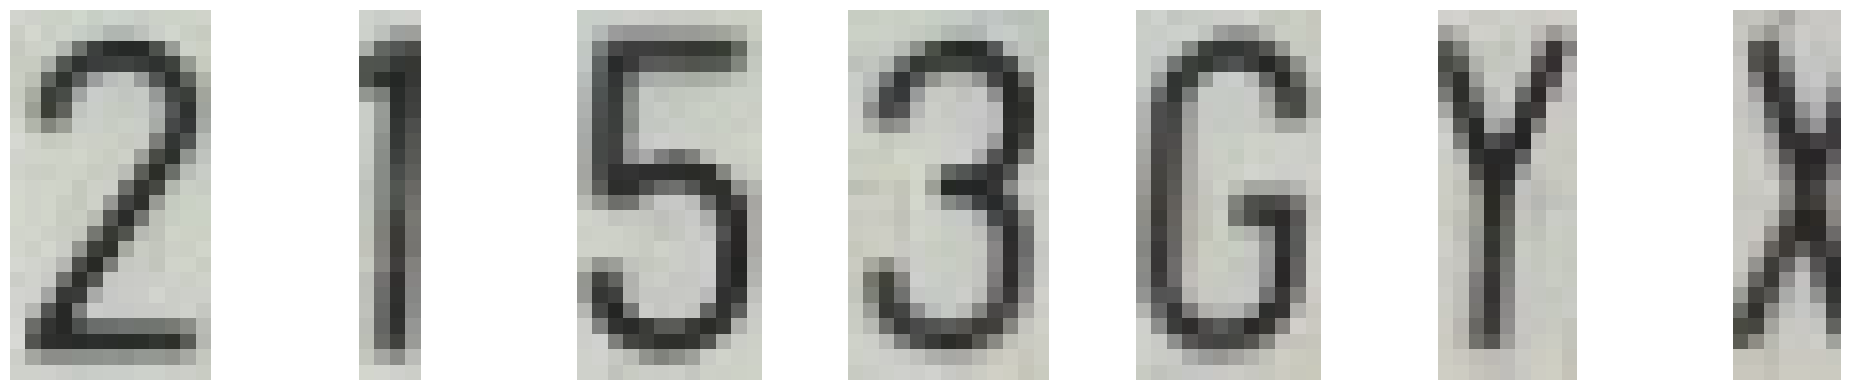

In [50]:
# Copy of original image
image_copy = plate.copy()

plate_digits = []

# Loop through the largest contours to extract and save each blob
for i, contour in enumerate(largest_contours):
    # Get the bounding box for the contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Calculate margins
    margin_x = int(0.1 * w)
    margin_y = int(0.1 * h)
    
    # Define new coordinates with margins
    x1 = max(0, x - margin_x)  # Ensure it doesn't go below 0
    y1 = max(0, y - margin_y)  # Ensure it doesn't go below 0
    x2 = min(image_copy.shape[1], x + w + margin_x)  # Ensure it doesn't go beyond image width
    y2 = min(image_copy.shape[0], y + h + margin_y)  # Ensure it doesn't go beyond image height

    # Extract the region of interest (ROI) from the original image
    blob_image = image_copy[y1:y2, x1:x2]

    # Append image to plates digits list
    plate_digits.append(blob_image)

    # Save the extracted blob image
    blob_filename = os.path.join(output_dir, f'blob_{i + 1}.jpg')
    cv2.imwrite(blob_filename, blob_image)

# Display blob images 
fig, axs = plt.subplots(1, 7, figsize=(20, 4))  # Adjust figsize for better spacing

# Loop through the blob images and display each one
for ax, image in zip(axs, plate_digits):
    ax.imshow(image)
    ax.axis('off')
plt.tight_layout()
plt.show()